## Learning Rate Calibration of Gradient Descent in PyBOP

In this notebook, we calibrate the learning rate for the gradient descent optimiser on a parameter identification problem. The gradient descent learning rate is taken as the `sigma0` value passed to the `pybop.Optimisation` class, or via `problem.sigma0` or `cost.sigma0` if it is passed earlier in the workflow.

### Setting up the Environment

Before we begin, we need to ensure that we have all the necessary tools. We will install PyBOP from its development branch and upgrade some dependencies:

In [1]:
%pip install --upgrade pip ipywidgets
%pip install pybop -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Importing Libraries

With the environment set up, we can now import PyBOP alongside other libraries we will need:

In [2]:
import numpy as np

import pybop

## Generating Synthetic Data

To demonstrate parameter estimation, we first need some data. We will generate synthetic data using a forward model, which requires defining a parameter set and the model itself.

### Defining Parameters and Model

We start by creating an example parameter set, constructing the single-particle model (SPM) and generating the synthetic data.

In [3]:
parameter_set = pybop.ParameterSet.pybamm("Chen2020")
parameter_set.update(
    {
        "Negative electrode active material volume fraction": 0.65,
        "Positive electrode active material volume fraction": 0.51,
    }
)
model = pybop.lithium_ion.SPM(parameter_set=parameter_set)
init_soc = 0.4
experiment = pybop.Experiment(
    [
        (
            "Discharge at 0.5C for 6 minutes (4 second period)",
            "Charge at 0.5C for 6 minutes (4 second period)",
        ),
    ]
    * 2
)
values = model.predict(init_soc=init_soc, experiment=experiment)

### Adding Noise to Voltage Data

To make the parameter estimation more realistic, we add Gaussian noise to the data.

In [4]:
sigma = 0.002
corrupt_values = values["Voltage [V]"].data + np.random.normal(
    0, sigma, len(values["Voltage [V]"].data)
)

## Identifying the Parameters

We will now set up the parameter estimation process by defining the datasets for optimisation and selecting the model parameters we wish to estimate.

### Creating a Dataset

The dataset for optimisation is composed of time, current, and the noisy voltage data:

In [5]:
dataset = pybop.Dataset(
    {
        "Time [s]": values["Time [s]"].data,
        "Current function [A]": values["Current [A]"].data,
        "Voltage [V]": corrupt_values,
    }
)

### Defining Parameters to Estimate

We select the parameters for estimation and set up their prior distributions and bounds:

In [6]:
parameters = pybop.Parameters(
    pybop.Parameter(
        "Negative electrode active material volume fraction",
        prior=pybop.Uniform(0.45, 0.7),
        bounds=[0.4, 0.8],
        true_value=0.65,
    ),
    pybop.Parameter(
        "Positive electrode active material volume fraction",
        prior=pybop.Uniform(0.45, 0.7),
        bounds=[0.4, 0.8],
        true_value=0.51,
    ),
)

### Setting up the Optimisation Problem with incorrect sigma value

With the datasets and parameters defined, we can set up the optimisation problem, its cost function, and the optimiser. For gradient descent, the `sigma0` value corresponds to the learning rate. Let's set this hyperparmeter incorrectly to view how we calibrate it. In this example, let's start with `sigma0=0.2`.

In [7]:
problem = pybop.FittingProblem(model, parameters, dataset, init_soc=init_soc)
cost = pybop.SumSquaredError(problem)
optim = pybop.GradientDescent(cost, sigma0=0.2, max_iterations=100)

NOTE: Boundaries ignored by Gradient Descent


### Running the Optimisation

We proceed to run the optimisation algorithm to estimate the parameters with the updated learning rate (`sigma0`).

In [8]:
x, final_cost = optim.run()

### Viewing the Estimated Parameters

After the optimisation, we can examine the estimated parameter values. In this case, the optimiser misses the optimal solution by a large amount.

In [9]:
x  # This will output the estimated parameters

array([0.64609807, 0.51472958])

Let's plot the time-series prediction for the given solution. As we suspected, the optimiser found a very poor solution. 

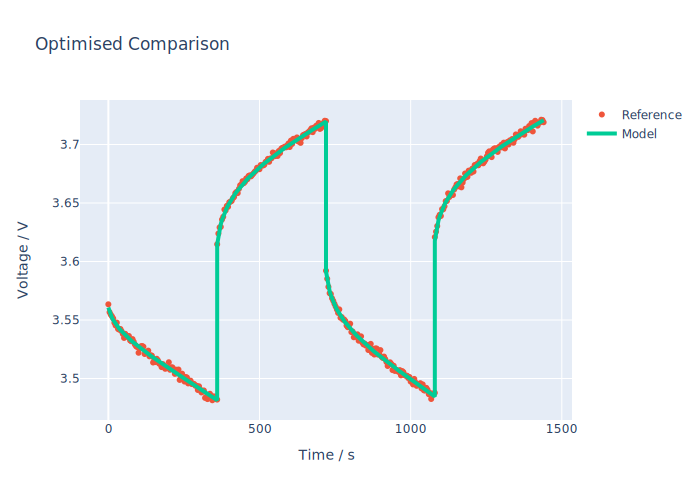

In [10]:
pybop.quick_plot(problem, problem_inputs=x, title="Optimised Comparison");

## Calibrating the Learning Rate 

Now that we've seen how poor an incorrect `sigma0` value is for this optimisation problem, let's calibrate this value to find the optimal solution in the lowest number of iterations.

In [11]:
sigmas = np.linspace(0.001, 0.08, 8)  # Change this to a smaller range for a quicker run
xs = []
optims = []
for sigma in sigmas:
    print(sigma)
    problem = pybop.FittingProblem(model, parameters, dataset, init_soc=init_soc)
    cost = pybop.SumSquaredError(problem)
    optim = pybop.GradientDescent(cost, sigma0=sigma, max_iterations=100)
    x, final_cost = optim.run()
    optims.append(optim)
    xs.append(x)

0.001
NOTE: Boundaries ignored by Gradient Descent
0.012285714285714285
NOTE: Boundaries ignored by Gradient Descent
0.023571428571428573
NOTE: Boundaries ignored by Gradient Descent
0.03485714285714286
NOTE: Boundaries ignored by Gradient Descent
0.046142857142857145
NOTE: Boundaries ignored by Gradient Descent
0.05742857142857143
NOTE: Boundaries ignored by Gradient Descent
0.06871428571428571
NOTE: Boundaries ignored by Gradient Descent
0.08
NOTE: Boundaries ignored by Gradient Descent


In [12]:
for optim, sigma in zip(optims, sigmas):
    print(
        f"| Sigma: {sigma} | Num Iterations: {optim._iterations} | Best Cost: {optim.pints_optimiser.f_best()} | Results: {optim.pints_optimiser.x_best()} |"
    )

| Sigma: 0.001 | Num Iterations: 100 | Best Cost: 0.008590687346571011 | Results: [0.58273999 0.64430015] |
| Sigma: 0.012285714285714285 | Num Iterations: 100 | Best Cost: 0.0017482878947612424 | Results: [0.62229759 0.5406604 ] |
| Sigma: 0.023571428571428573 | Num Iterations: 100 | Best Cost: 0.0013871420979637958 | Results: [0.63941964 0.52140605] |
| Sigma: 0.03485714285714286 | Num Iterations: 100 | Best Cost: 0.001571369568098984 | Results: [0.62907481 0.53267599] |
| Sigma: 0.046142857142857145 | Num Iterations: 28 | Best Cost: 0.0013533853388748253 | Results: [0.64673791 0.51409832] |
| Sigma: 0.05742857142857143 | Num Iterations: 25 | Best Cost: 0.0013584031053821507 | Results: [0.64390064 0.51673076] |
| Sigma: 0.06871428571428571 | Num Iterations: 74 | Best Cost: 0.0013568172573032275 | Results: [0.64444354 0.51631924] |
| Sigma: 0.08 | Num Iterations: 73 | Best Cost: 0.0013551215844470215 | Results: [0.64505654 0.51551585] |


Perhaps a better way to view this information is to plot the optimiser convergences,

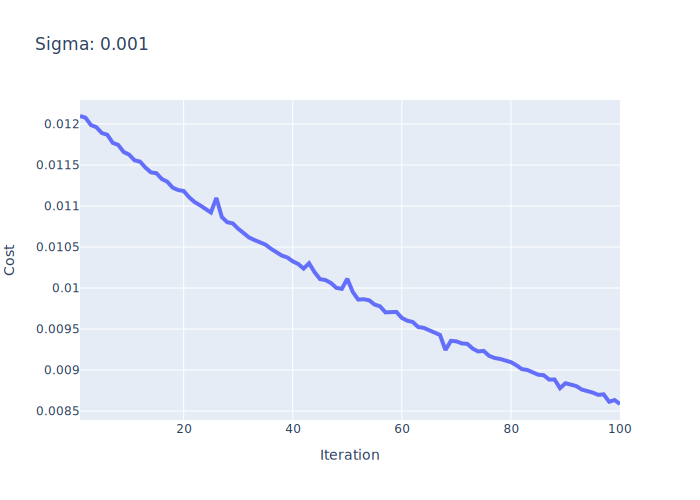

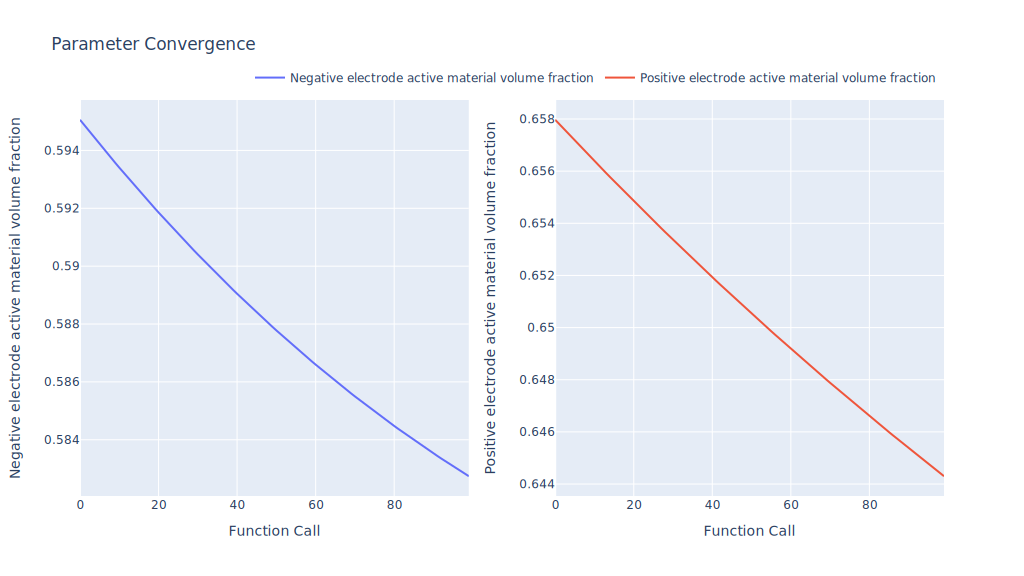

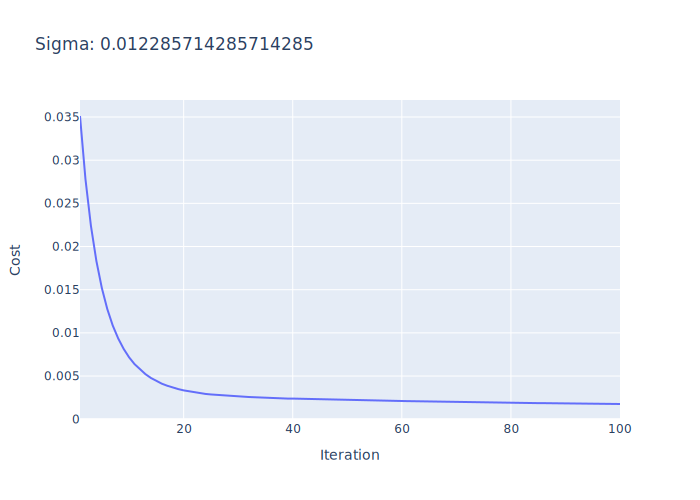

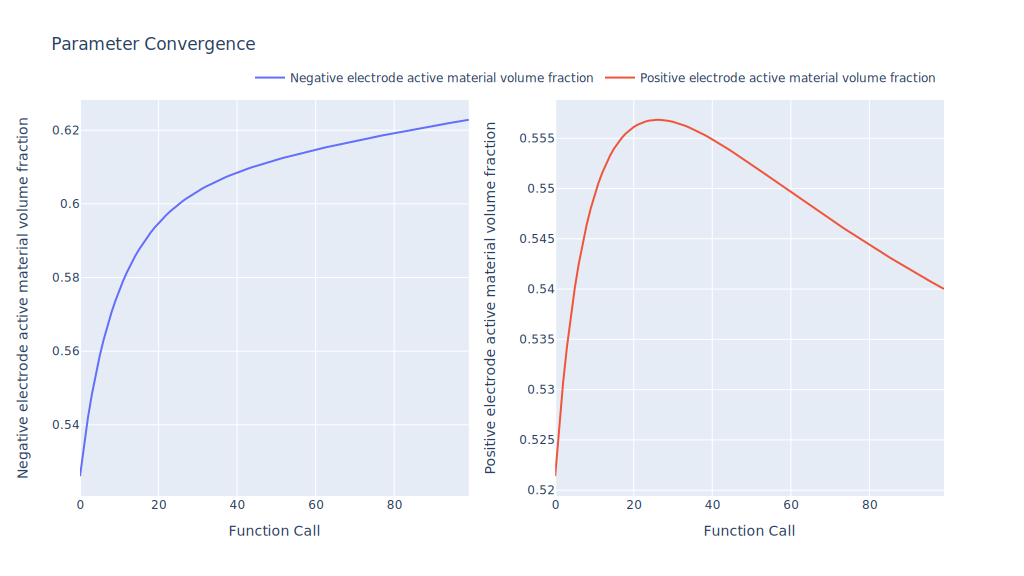

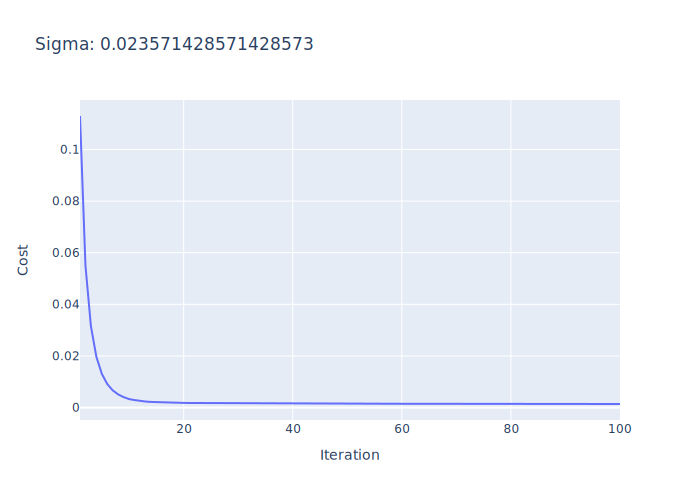

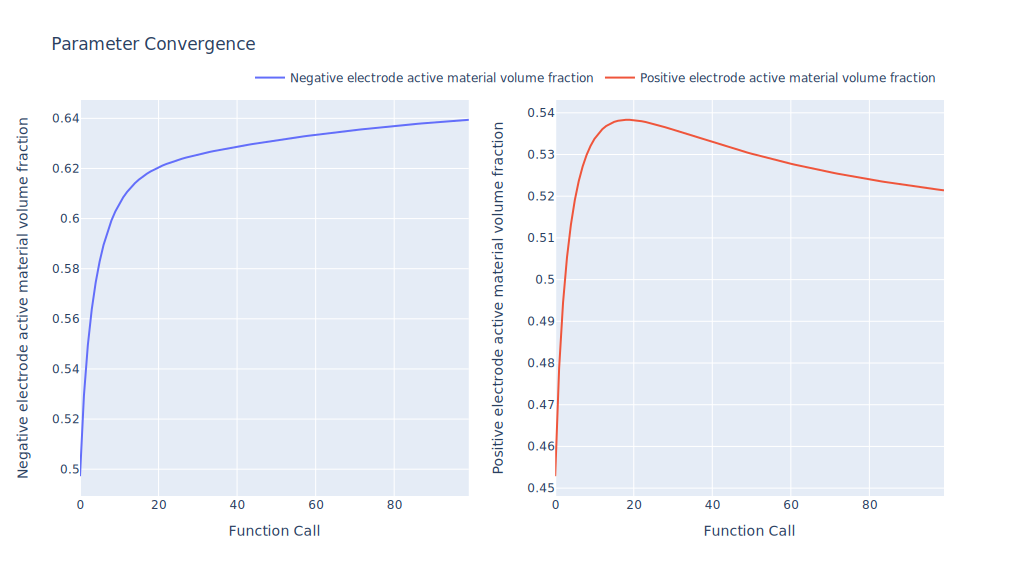

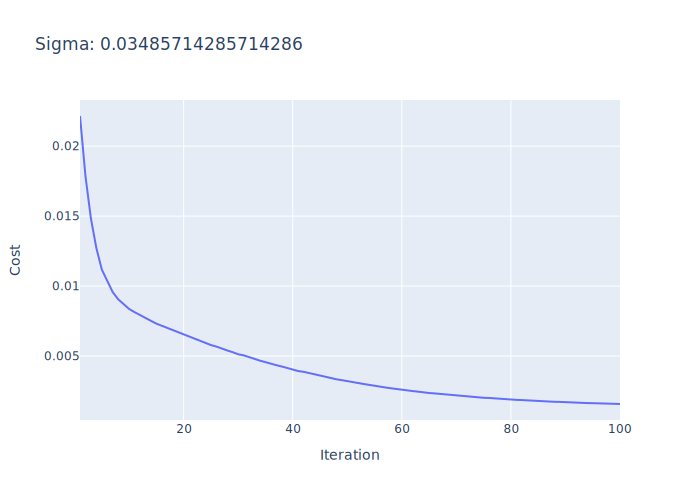

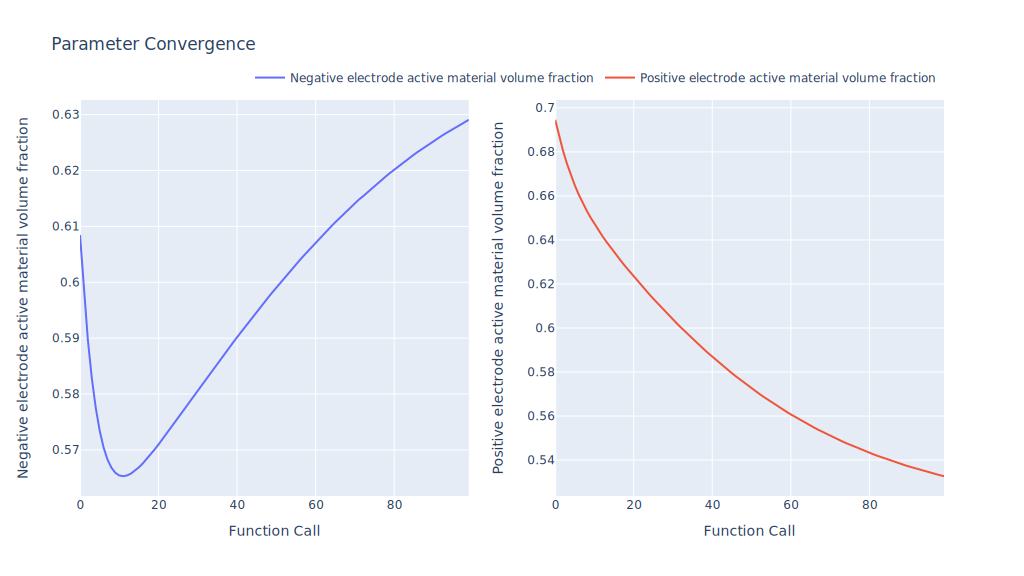

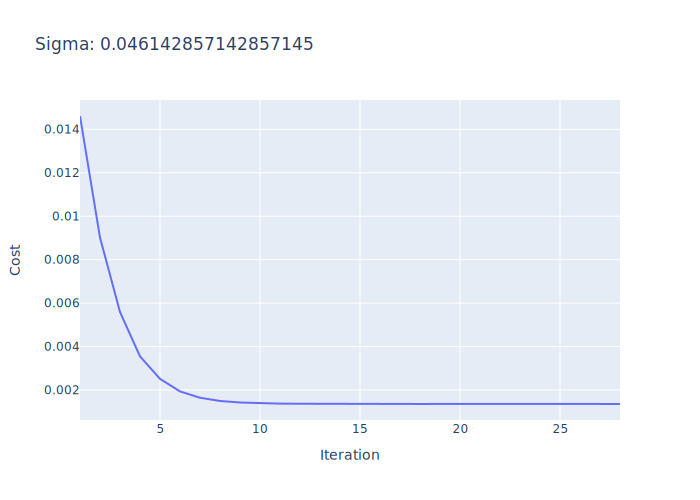

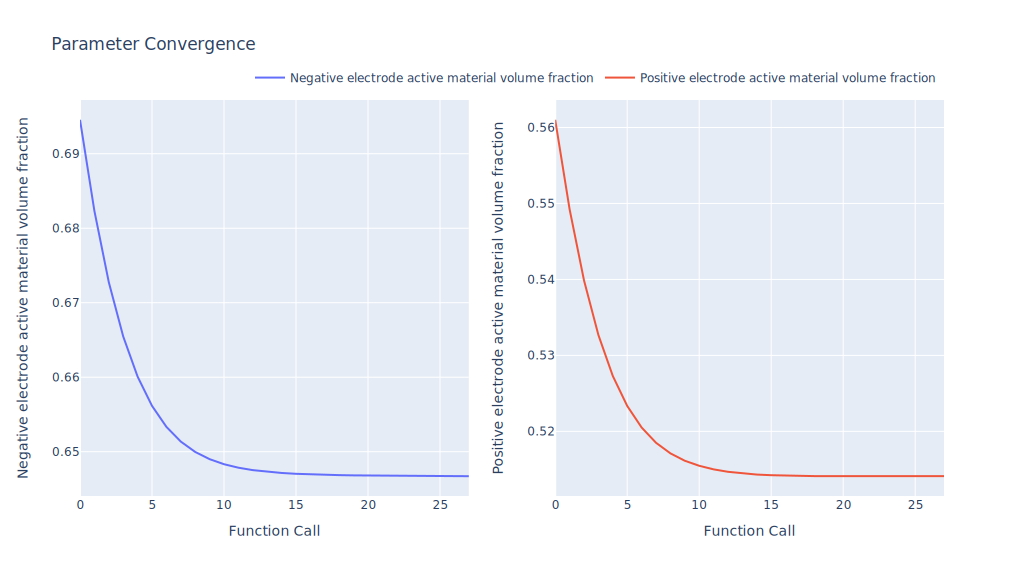

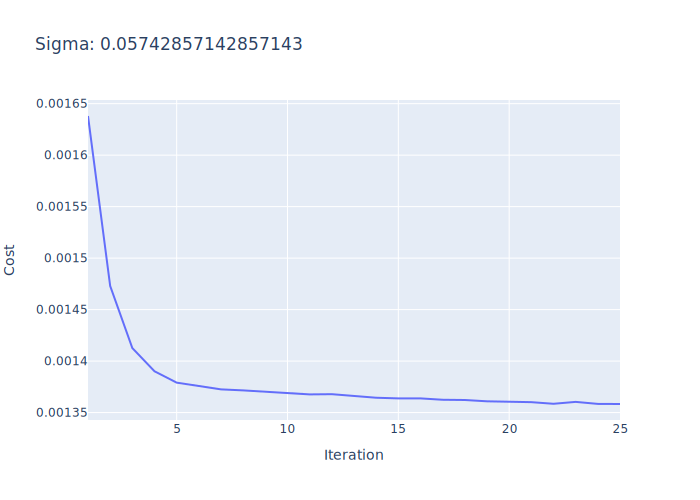

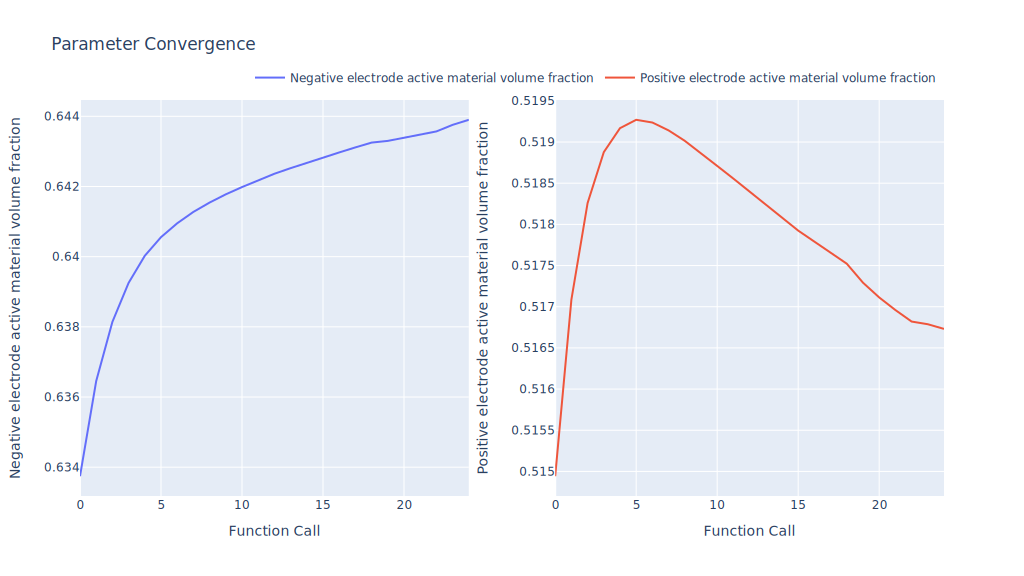

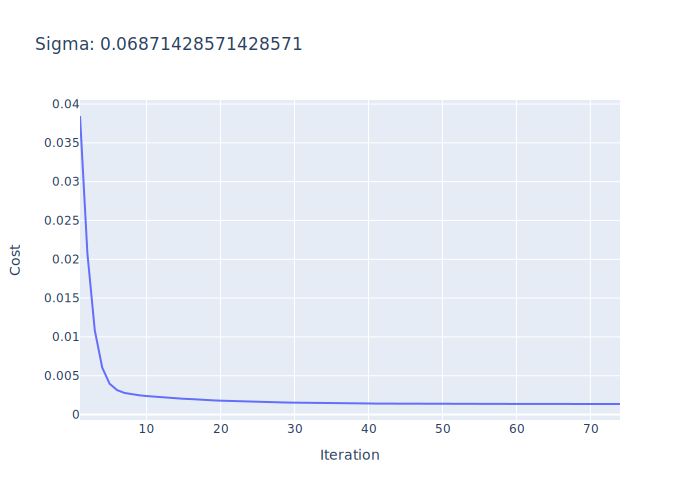

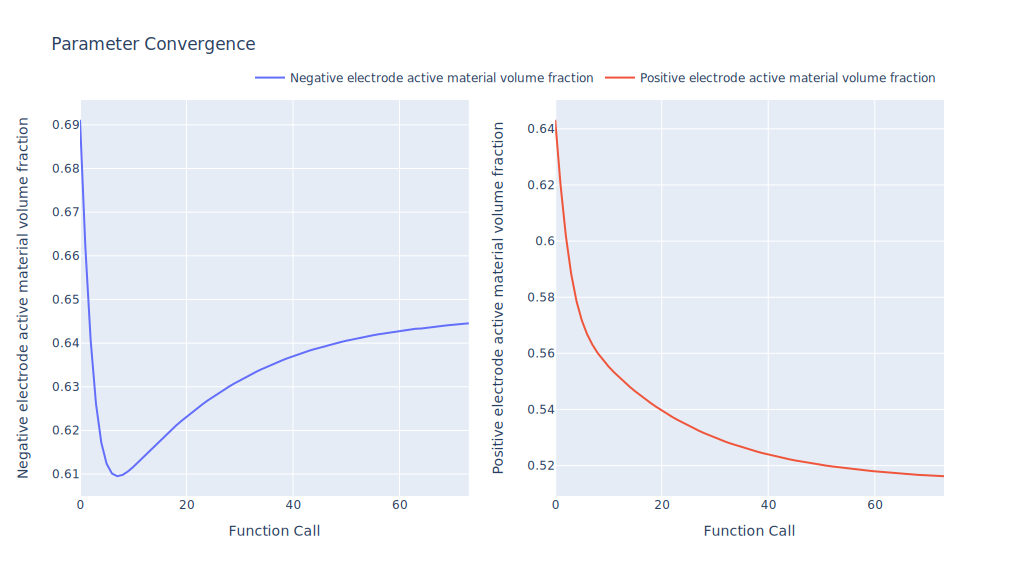

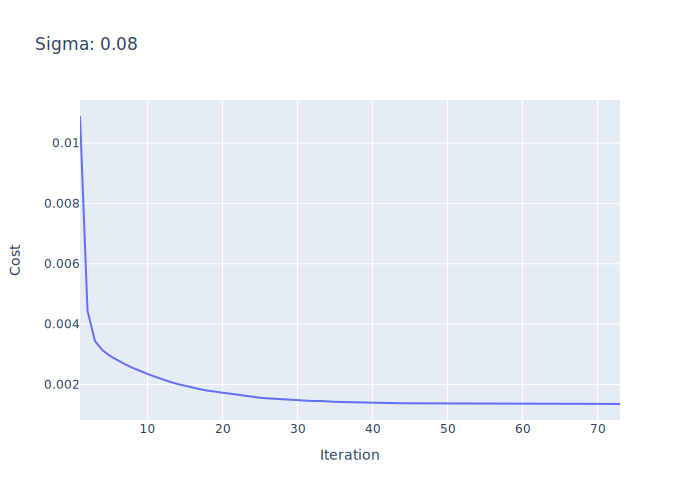

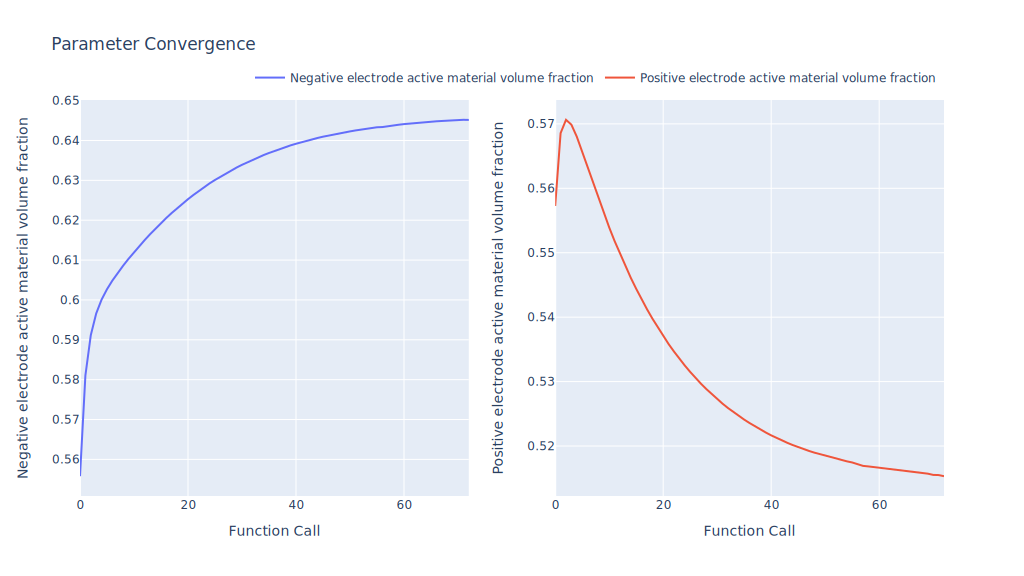

In [13]:
for optim, sigma in zip(optims, sigmas):
    pybop.plot_convergence(optim, title=f"Sigma: {sigma}")
    pybop.plot_parameters(optim)

### Cost Landscapes

Finally, we can visualise the cost landscape and the path taken by the optimiser:

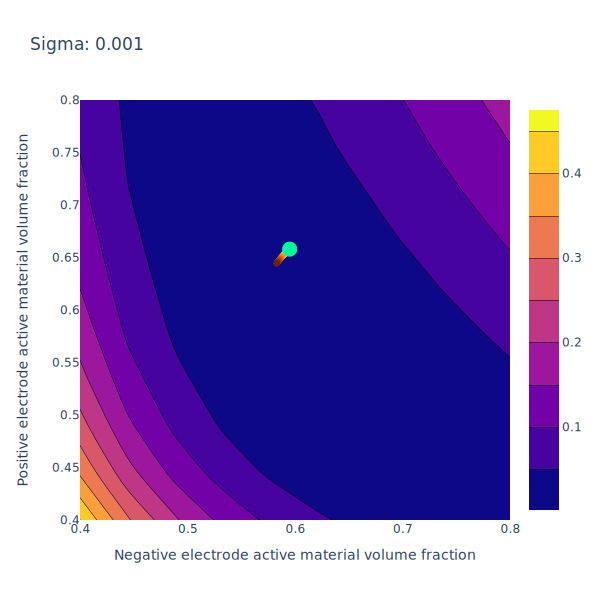

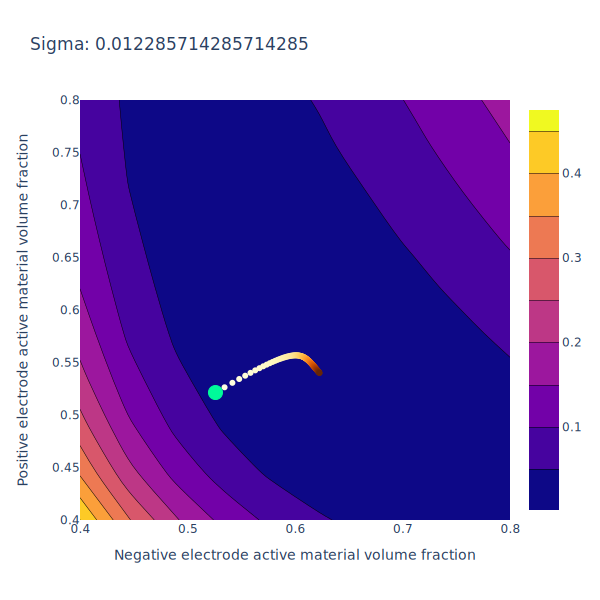

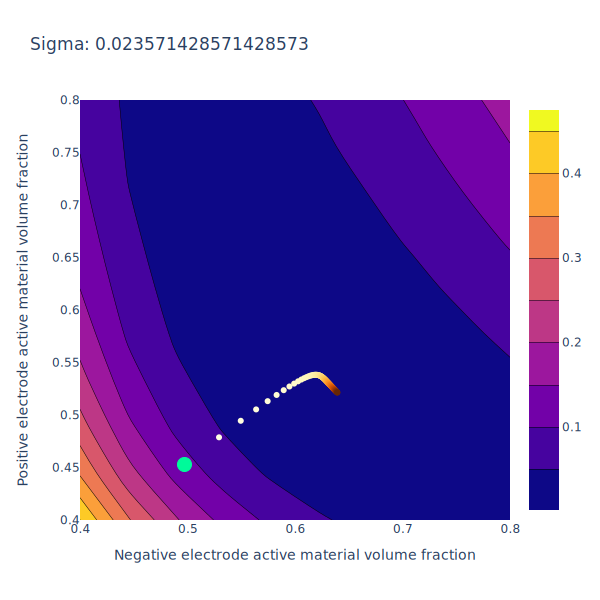

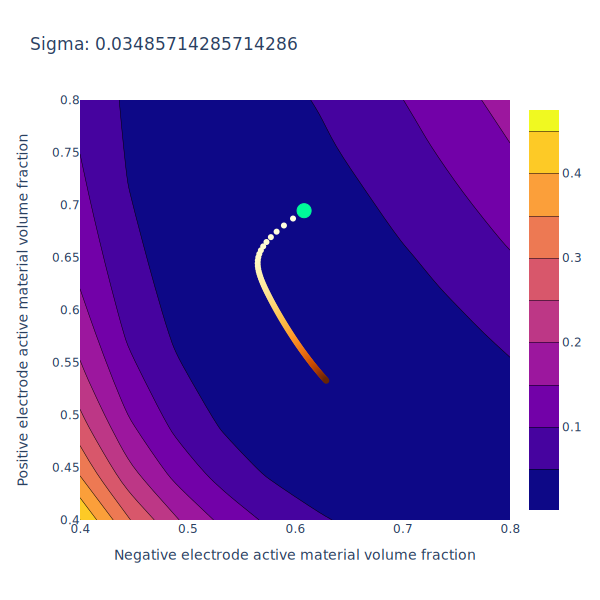

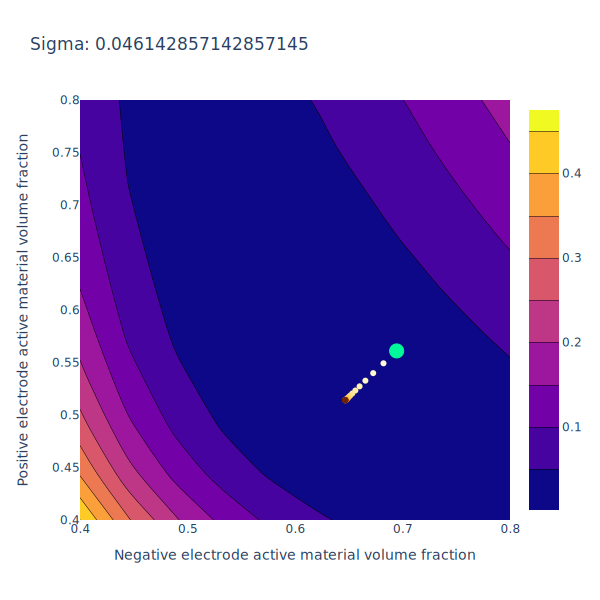

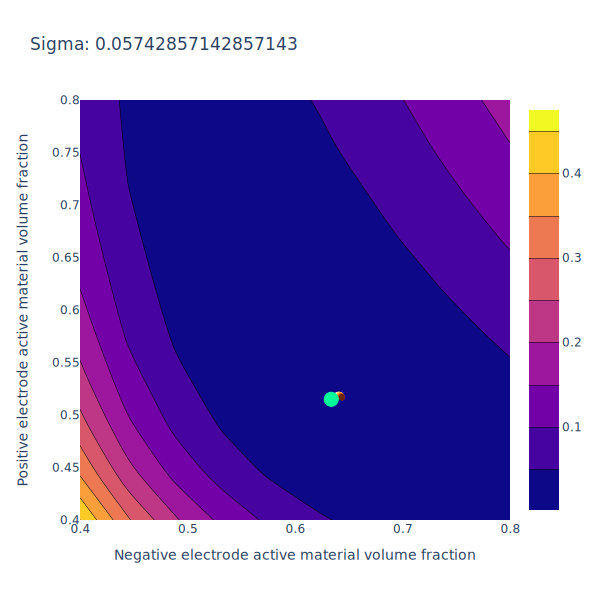

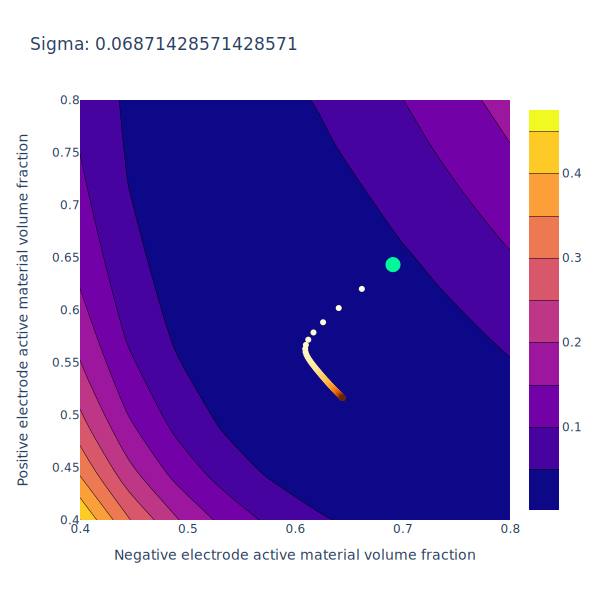

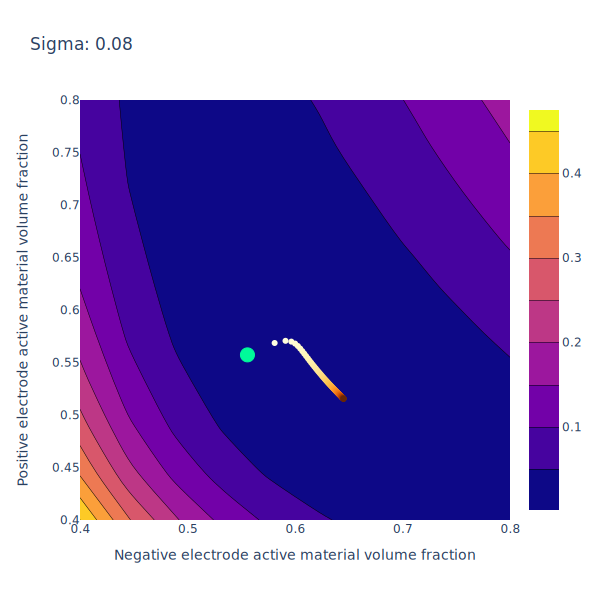

In [14]:
# Plot the cost landscape with optimisation path and updated bounds
bounds = np.array([[0.4, 0.8], [0.4, 0.8]])
for optim, sigma in zip(optims, sigmas):
    pybop.plot2d(optim, bounds=bounds, steps=10, title=f"Sigma: {sigma}")

### Updating the Learning Rate

Let's take `sigma0 = 0.08` as the best learning rate for this problem and look at the time-series trajectories.

NOTE: Boundaries ignored by Gradient Descent


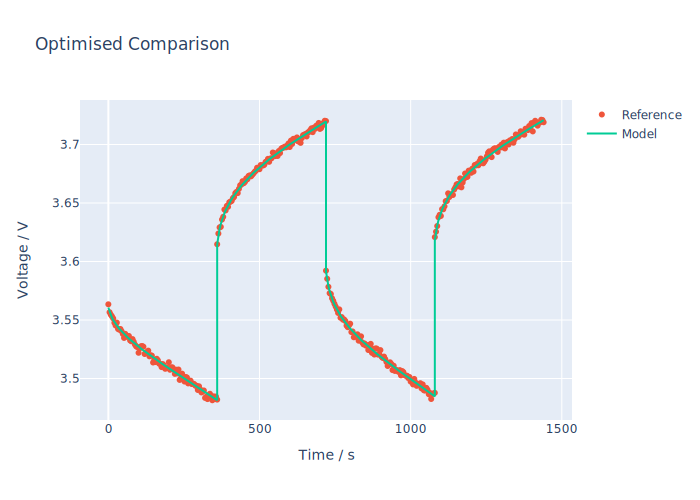

In [16]:
optim = pybop.Optimisation(cost, optimiser=pybop.GradientDescent, sigma0=0.08)
x, final_cost = optim.run()
pybop.quick_plot(problem, problem_inputs=x, title="Optimised Comparison");

### Conclusion

This notebook covers how to calibrate the learning rate for the gradient descent optimiser. This provides an introduction into hyper-parameter tuning that will be discussed in further notebooks.